In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
random.seed(101)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

这个notebook的目的是，通过探索非线性模型具体是怎么做预测的，来猜测一组数据的特征到底是怎么影响结果的。
我自己制造了一组数据，数据特征之间有一些相关性（x5和x6）。
然后数据的结果是特征数据做一些变换之后相加得来的。
假设我不知道这个数据结果是如何从数据转换过来的，希望通过机器学习以及模型解释来猜测特征数据是如何转换到数据结果的。
这里边用了Accumulative Local Effect（ALE）算法来解释的模型。
关于ALE，请参考论文:<https://arxiv.org/ftp/arxiv/papers/1612/1612.08468.pdf>

In [14]:
x1 = np.random.normal(10,3,12000)
x2 = np.random.normal(4,1,12000)
x3 = np.random.randint(10,20,12000)
x4 = np.random.uniform(1,12,12000)

x5 = x1+x2
x6 = x1*2 + 1
# y = 3*x1 + x2**2 + 1/x3 + sin(x4) + x5 + x6 + noise(00,0.3)
y = 3*x1 + x2**2 + 1/x3 + np.sin(x4) + np.random.normal(0,0.3,12000) + x5 + x6

In [15]:
def multi(x):
    return 3*x
def power(x):
    return x**2
def inverse(x):
    return 1/x
def sinn(x):
    return np.sin(x)
def cross(x):
    return x
def coll(x):
    return x
funcs = [multi,power,inverse,sinn,cross,coll]
effects_funcs = {f.__name__:f for f in funcs}

In [16]:
data = pd.DataFrame({
    'multi':x1,
    'power':x2,
    'inverse':x3,
    'sinn':x4,
    'cross':x5,
    'coll':x6,
    'y':y
})

pair plot在这个情景看不出来除了线性之外其它的关系。

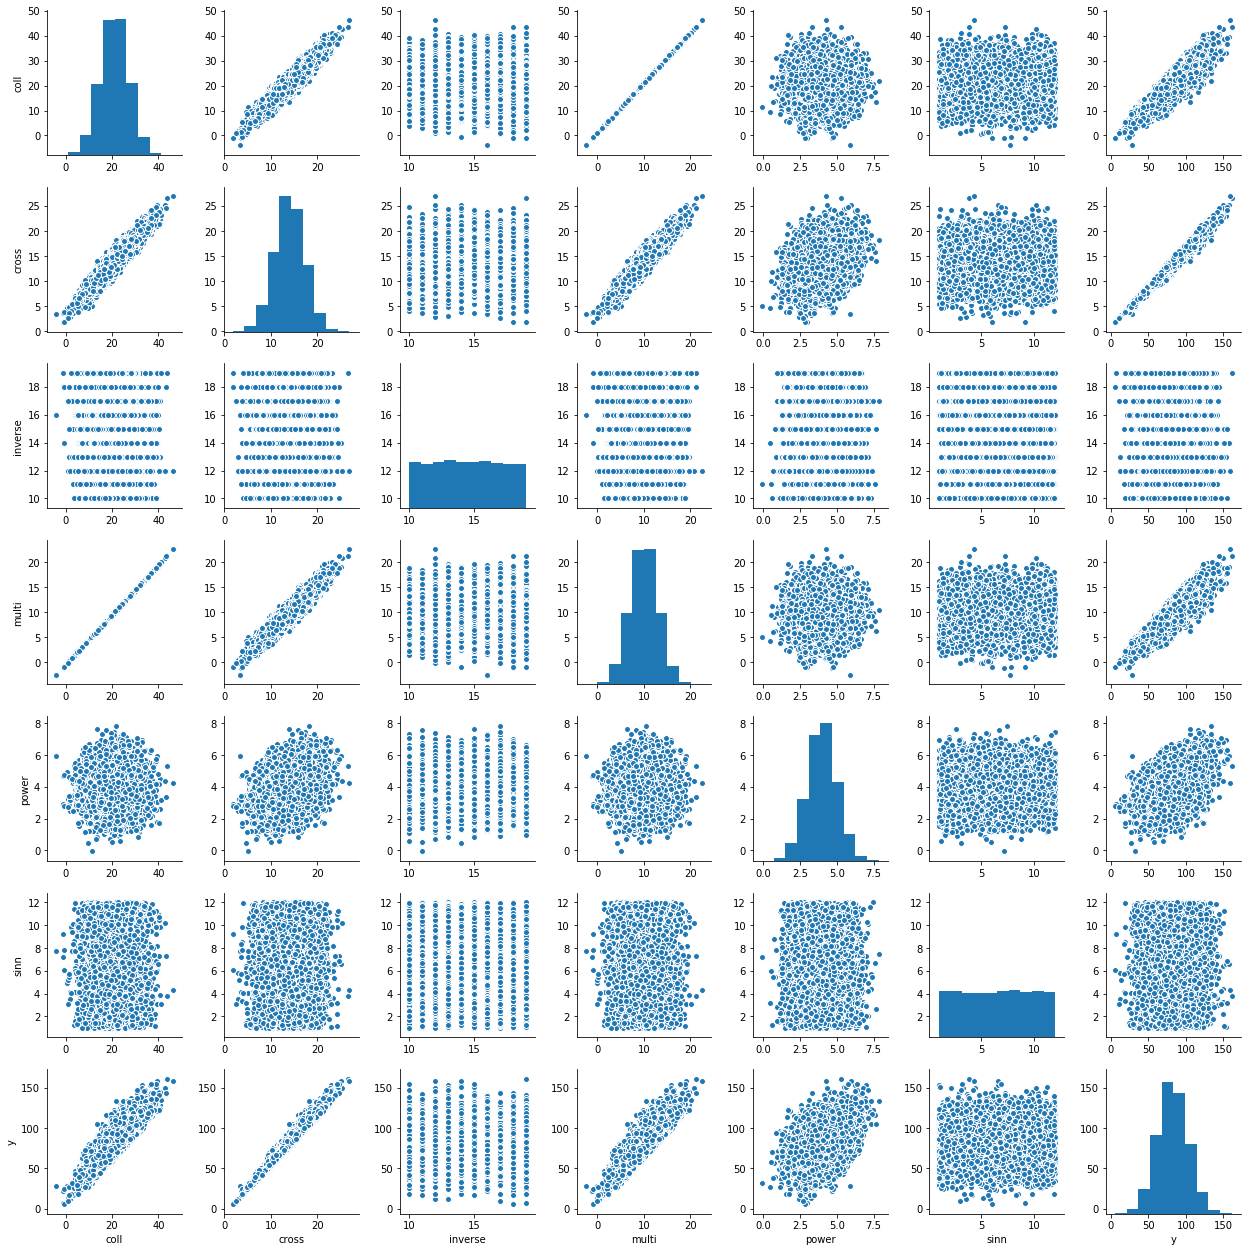

In [17]:
sns.pairplot(data);

In [18]:
## split data set
x_train,x_test,y_train,y_test = train_test_split(data.drop('y',axis=1),data.y,
                                                random_state=100,test_size=0.15)

In [24]:
rfr = RandomForestRegressor(n_estimators=66, random_state=500)
rfr.fit(x_train,y_train)
preds = rfr.predict(x_test)
r2_score(y_test,preds),mean_squared_error(y_test,preds)

(0.99866358864447513, 0.57320849148364161)

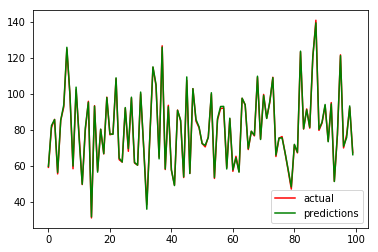

In [25]:
xline = np.arange(100)
plt.plot(xline,y_test[:100],color='red',label='actual')
plt.plot(xline,preds[:100],color='green',label='predictions');
plt.legend();

## explain model

In [21]:
def ale_vs_act(model,x,selected_feature):
    x = x.copy()
    
    col2idx = {col:i for i,col in enumerate(x.columns)}
    selected_idx = col2idx[selected_feature]
    x_matrix = x.copy().as_matrix()
    
    upper = x.loc[:,selected_feature].max()
    lower = x.loc[:,selected_feature].min()
    
    xline = np.linspace(lower,upper,1000).tolist()
    n_intervals = len(xline)
    interval_values = []
    interval_num = []
    total_num = x_matrix.shape[0]
    # get mean diff of every intervals
    for i in np.arange(1,n_intervals):
        im = x_matrix[(x_matrix[:,selected_idx]>=xline[i-1]) & (x_matrix[:,selected_idx]<xline[i])]
        interval_num.append(im.shape[0])
        if im.shape[0]==0:
            interval_values.append(0)
        else:
            im[:,selected_idx]=xline[i-1]
            lower_bound = model.predict(im)
            im[:,selected_idx]=xline[i]
            upper_bound = model.predict(im)
            interval_values.append(np.mean(upper_bound-lower_bound))
        
    # accumulate the interval values
    interval_acc = np.cumsum(interval_values)
    # calculate average overall effects by summing up all interval values and divide it with total num of records
    mean_effects = np.sum(interval_acc)/total_num
    # get interval values by deducing the values with the average effects
    ale_values = interval_acc - mean_effects
    
    effects = effects_funcs[selected_feature](np.array(xline))
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.plot(xline[1:],ale_values)
    ax1.set_title('Approximated Effects(ALE) vs Actual Effects')
    #ax1.set_xlabel('{}'.format(selected_feature))
    ax1.set_ylabel('ALE')
    ax2.plot(xline,effects,color='green',label='Actual_effects');
    ax2.set_xlabel('{}'.format(selected_feature))
    ax2.set_ylabel('Actual Effects')
    plt.show();

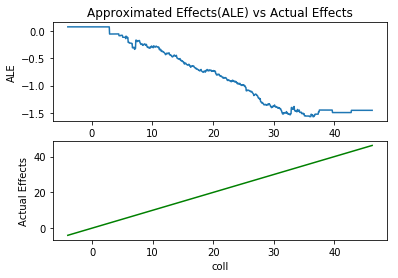

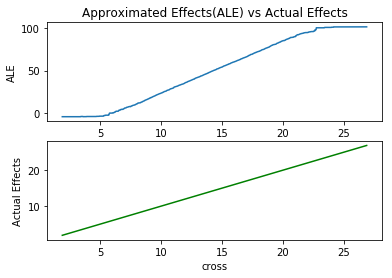

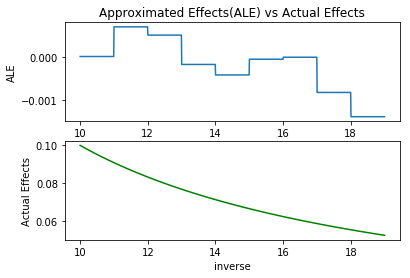

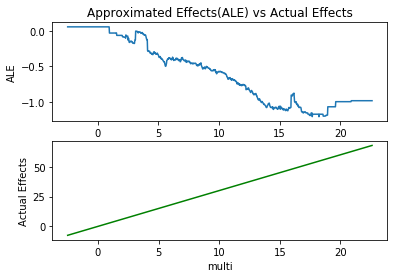

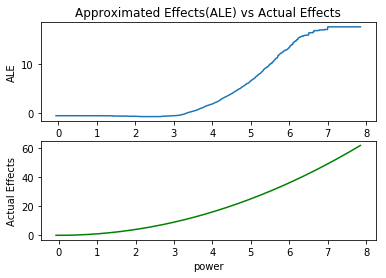

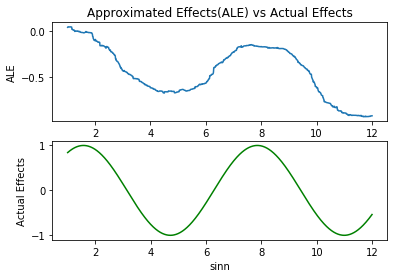

In [26]:
feat_data = data.drop('y',axis=1).copy()
for feat in feat_data.columns:
    ale_vs_act(rfr,feat_data,feat)

有两个关系错了，其它的大体形状是对的。当然scales差很远。